# Autoregressive Model Fort Time Series 

In [1]:
import plotly.express as px 
import pandas as pd 

Read Data

In [2]:
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data["Month"])

Plot passsangers

In [3]:
def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    
    fig = px.line(df, x='Month', y=y, labels = {'Month' : 'Date'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text="Airline Passengers",
                      width=650, title_x=0.5, height=400)
    
    return fig.show()

plot_passenger_volumes(df=data, y='#Passengers')

In [4]:
# Import packages 
from scipy.stats import boxcox

# Make the target stationary
data['Passengers_boxcox'], lan = boxcox(data['#Passengers']) # normaliza e estabiliza a variância
data['Passenger_stationary'] = data['Passengers_boxcox'].diff() #remove tendência

# Plot the sationary airline passenger data 
plot_passenger_volumes(df=data, y='Passenger_stationary')

Exigência de estacionariedade em séries temporais, devido ao fato de que muitos modelos estatísticos clássicos, assumes que os parâmetros do processo gerador da série não  mudam ao longo do tempo.

Modeling

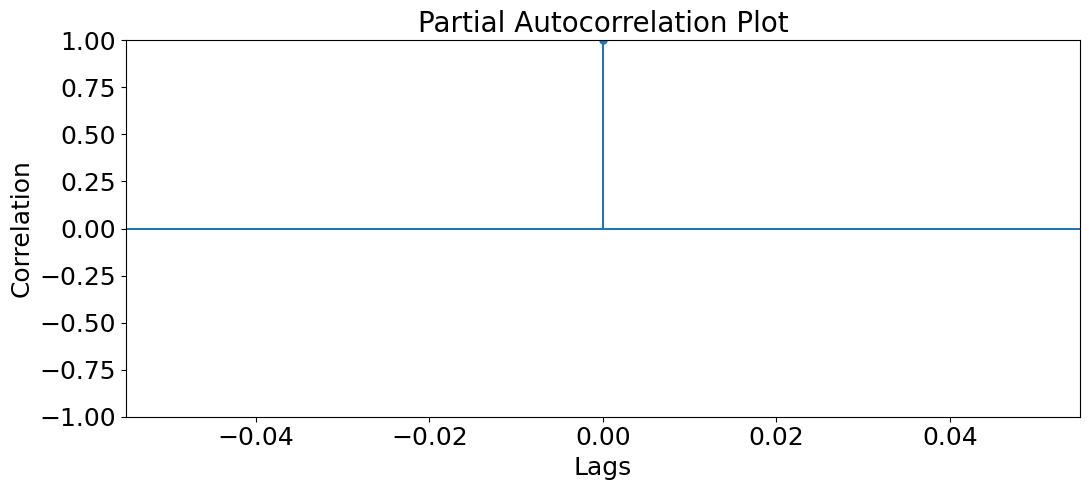

In [18]:
# Packages 
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_pacf

# Plot partial autocorrelation
plt.rc("figure", figsize=(11, 5))
plot_pacf(data['Passenger_stationary'], method='ywm')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()


In [32]:
# Import packages 
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Split and train and test 
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Remover o valor NaN
train_clean = train['Passenger_stationary'].dropna()

# Build AR model 
selector = ar_select_order(train_clean, 15)

model = AutoReg(train_clean, lags=selector.ar_lags).fit()

/home/clara/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/home/clara/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/home/clara/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



Results

In [40]:
# Import packages 
from scipy.special import inv_boxcox
import plotly.graph_objects as go 

# Get forecasts and covert to actual passanger volumes 
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []

for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Passengers_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lan)

def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')
    
    return fig.show()

# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')

/home/clara/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/clara/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



As previsões do nosso modelo autorregressivo capturaram adequadamente a tendência e a sazonalidade na série temporal. No entanto, a sazonalidade foi capturada como resultado do modelo ter uma ordem (lags) de 13. Isso significa que ele inclui todas as defasagens do ano anterior (uma para cada mês) para prever, o que o leva a captar facilmente a sazonalidade devido à sua regularidade.